Importing Libraries

In [1]:
import requests
from bs4 import BeautifulSoup
import os
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
from datetime import datetime
import pandas as pd
from selenium.webdriver.chrome.options import Options
from concurrent.futures import ThreadPoolExecutor
from skimage.feature import local_binary_pattern
import cv2
import numpy as np


In [10]:
url_dict ={
    "bellanaija": ["https://www.bellanaijastyle.com/hawa-lagos-fw-2025/"]
    }

In [11]:
driver = webdriver.Chrome()

for web_page, urls in url_dict.items():
    folder = os.path.join('hawa_images', web_page)
    if os.path.exists(folder):
        continue
    os.makedirs(folder, exist_ok=True)

    for url in urls:
        driver.get(url)
        time.sleep(15)

        elements = driver.find_elements(By.TAG_NAME, 'img')
        print(f"Found {len(elements)} image elements.")

        count = 0
        for index, img in enumerate(elements):
            src = img.get_attribute('src')
            if src and src.startswith("http"):
                try:
                    img_data = requests.get(src).content
                    filename = f"{'hawa'}_{web_page}_{index+1}.jpg"
                    path = os.path.join(folder, filename)
                    with open((path), 'wb') as f:
                        f.write(img_data)
                except Exception as e:
                    print(f"Error downloading image {src}: {e}")
                    continue
        

driver.quit()
print("All Images from all websites downloaded.")

Found 54 image elements.
All Images from all websites downloaded.


VGG16 MODEL - COLOUR EXTRACTION(DONE)

PREPROCESSING - VGG16

dataset_dict = {"hawa_images": ["bellanaija"]}

processed_pics = {}

for hawa, folders in dataset_dict.items():
    hawa_img = []

    for folder in folders:
        folder_dir = os.path.join('hawa_images', folder)
        new_dir = os.path.join(folder_dir, "processed")
        os.makedirs(new_dir, exist_ok = True)
        
        for img_name in os.listdir(folder_dir):
            img_path = os.path.join(folder_dir, img_name)
           
            if not img_name.lower().endswith(('.jpg','.jpeg', '.png')):
                continue
            
            if "processed" in img_path:
                continue

            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (224,224))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_norm = img / 255.0
                    hawa_img.append(img_norm)
                    cv2.imwrite(os.path.join(new_dir, img_name), cv2.cvtColor((img_norm * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
            except Exception as e:
                print(f"Error processing image {img_name}: {e}")
                continue
    processed_pics[hawa] = np.array(hawa_img)
    print(f"Processed {len(hawa_img)} images for {hawa}.\n")

print("All brands have been preprocessed!")

In [12]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

mini_CNN = VGG16(weights='imagenet', include_top=False, pooling='avg')

imgen = ImageDataGenerator(rescale=1./255)
gen = imgen.flow_from_directory('hawa_images', target_size=(224,224), batch_size=32, class_mode=None, shuffle=False)

features = mini_CNN.predict(gen)

filenames = gen.filenames
np.save('hawa_features.npy', features)
np.save('hawa_files.npy', filenames)

Found 33 images belonging to 1 classes.


c:\Users\User\Desktop\Lagos-FW-2024-Analysis\Lagos-FW-2024-Analysis-1\fw_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 736ms/step


COLOUR EXTRACTION - VGG16

def extract_colors(image_path, n_colors=5):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    
    # Reshape pixels for clustering
    pixels = img.reshape(-1, 3)
    
    # Use KMeans to find dominant colors
    from sklearn.cluster import KMeans
    from skimage.feature import local_binary_pattern
    
    kmeans = KMeans(n_clusters=n_colors, random_state=42)
    kmeans.fit(pixels)
    
    colors = kmeans.cluster_centers_.astype(int)
    counts = np.bincount(kmeans.labels_)
    
    # Sort by frequency
    sorted_colors = colors[np.argsort(-counts)]
    return sorted_colors

# def extract_sihlouette(image_path):
#     img = cv2.imread(image_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (224,224))
#     img = img/255.0
#     img = np.expand_dims(img, axis=0)
#     X = mini_CNN.predict(img, verbose=0)
#     return X.flatten()

# def extract_texture(image_path, P=8, R=1):
#     img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     img = cv2.resize(img, (224,224))
    
#     lbp = local_binary_pattern(img, P, R, method="uniform")
#     (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    
#     hist = hist.astype("float")
#     hist /= (hist.sum() + 1e-6)
    
#     return hist

brand_colors = []
# silhouettes = []
# textures = []

folder = 'hawa_images/bellanaija/processed'
for img_name in os.listdir(folder):
    if img_name.endswith(('.jpg','.png')):
        img_path = os.path.join(folder, img_name)
        colors = extract_colors(img_path, n_colors=3)
        brand_colors.extend(colors)

        # silhouettes.append(extract_sihlouette(img_path))
        # textures.append(extract_texture(img_path))

# Convert to NumPy array
brand_colors = np.array(brand_colors)
# silhouettes_features = np.array(silhouettes)
# textures = np.array(textures)


# Optional: cluster all colors across images to find overall dominant colors
from sklearn.cluster import KMeans
n_clusters = 13
kmeans_all = KMeans(n_clusters, random_state=42)
kmeans_all.fit(brand_colors)
common_colors = kmeans_all.cluster_centers_.astype(int)

print("Most common colors for brand:", common_colors)


import matplotlib.pyplot as plt

plt.figure(figsize=(6,1))
plt.imshow([common_colors])
plt.axis('off')
plt.show()


labels = kmeans_all.fit_predict(brand_colors)

# Calculate fraction of each dominant color
color_percentages = []

for i in range(n_clusters):
    color_fraction = np.sum(labels == i) / len(labels)
    color_percentages.append(color_fraction * 100)

for color, perc in zip(common_colors, color_percentages):
    print(f"Colour {color} appears in {perc:.2f}% of the collection")


DEEPLABV3 MODEL - COLOUR EXTRACTION (DONE), SIHLOUETTE EXTRACTION, FABRIC EXTRACTION

In [13]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import numpy as np
from torchvision.transforms.functional import resize
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter

In [14]:
preprocess = transforms.Compose([
    transforms.Resize((520,520)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset_dict = {"hawa_images": ["bellanaija"]}
preprocessed_images = {}

for hawa, folders in dataset_dict.items():
    hawa_img = []

    for folder in folders:
        folder_dir = os.path.join(hawa, folder)
        
        for img_name in os.listdir(folder_dir):
            img_path = os.path.join(folder_dir, img_name)
           
            if not img_name.lower().endswith(('.jpg','.jpeg', '.png')):
                continue
            
            if "segmented" in img_path:
                continue

            try:
                input_image = Image.open(img_path).convert("RGB")
                input_tensor = preprocess(input_image)
                hawa_img.append(input_tensor)
            
            except Exception as e:
                print(f"Error processing image {img_name}: {e}")
                continue

    preprocessed_images[hawa] = torch.stack(hawa_img)
    print(f"Segmented {len(hawa_img)} images for {hawa}.\n")

Segmented 33 images for hawa_images.



In [24]:
COLOURS = {
    # --- Warm Tones (The Maroons & Earth Tones) ---
    "Maroon": [40, 160, 140],        # The deep red lace dresses
    "Terracotta": [120, 160, 160],   # The orange-brown fringed skirts
    "Chocolate Brown": [50, 140, 150],# Dark brown structured pieces
    "Rust": [115, 155, 165],         # The burnt orange mid-tones
    "Mustard": [170, 140, 190],      # Golden/yellowish earth tones
    "Burgundy": [45, 165, 135],        # Deep wine reds
    "Brick Red": [95, 165, 155],       # Clay-based reds
    "Burnt Sienna": [110, 155, 170],   # Earthy orange-red
    "Copper": [135, 150, 175],         # Metallic warm brown
    "Sand": [200, 135, 155],           # Light warm neutral
    "Olive Green": [120, 120, 160],    # Earthy green
    "Forest Green": [60, 115, 140],    # Deep green
    "Sage Green": [180, 120, 145],     # Soft desaturated green
    "Mint Green": [210, 115, 140],     # Pale cool green
    "Khaki": [155, 125, 160],          # Neutral military green

    # --- The "Mauve" Group (The AI's favorite) ---
    "Mauve": [140, 150, 120],        # The dusty purple/grey fabric
    "Light Purple": [190, 145, 110], # Pale reflections on the Akwete
    "Dusty Rose": [180, 150, 135],     # Muted pinks
    "Blush Pink": [210, 150, 140],     # Light skin-tone pink
    "Rose Red": [130, 175, 145],       # Saturated pink-red
    "Coral": [170, 165, 155],          # Warm pink-orange
    "Salmon": [185, 155, 150],         # Soft peach-pink
    "Plum": [85, 165, 115],            # Deep purple
    "Lavender": [205, 145, 120],       # Light purple fabric
    "Eggplant": [60, 160, 115],        # Dark muted purple
    "Wine": [50, 170, 130],            # Rich red-purple
    "Lilac Grey": [190, 140, 125],     # Muted pastel purple

    # --- Cool Tones (The Teals & Blues) ---
    "Dark Teal": [70, 110, 120],     # The blue-green headwraps
    "Navy Blue": [40, 100, 110],     # Deep blue woven threads
    
    # --- Neutrals & Brights ---
    "Off-White": [240, 128, 132],    # The white shirts and base layers
    "Hot Pink": [150, 210, 130],     # The vibrant trousers
    "Cyan": [160, 80, 130],          # Bright blue accents
    "Charcoal": [60, 128, 128],      # Dark grey shadows/details
    #"Light Gray": [192, 128, 128],   # Pale grey fabric highlights
    "Black": [30, 128, 128],          # Deepest black structural lines
    "Warm Grey": [150, 130, 135],      # Fabric mid-grey
    "Cool Grey": [150, 125, 125],      # Blue-tinted grey
    "Taupe": [140, 135, 145],          # Brown-grey neutral
    "Ivory": [230, 130, 140],          # Warm off-white
    "Deep Brown": [40, 135, 145],       # Very dark brown

    "Steel Blue": [110, 115, 125],     # Grey-blue textiles
    "Indigo": [45, 120, 105],          # Deep blue-purple
    "Denim Blue": [80, 115, 120],      # Worn denim tones
    "Sky Blue": [200, 105, 125],       # Light airy blue
    "Petrol Blue": [65, 110, 115],     # Dark blue-green

        # --- LagosFW25 Runway Colours ---
    "Indigo Blue": [35, 105, -10],         # Deep rich blue
    "Royal Blue": [50, 100, -15],         # Vibrant runway denim/structured blue
    "Powder Blue": [190, 105, -5],        # Soft airy blue (light cotton)
    "Sky Blue Pastel": [200, 105, -8],    # Gentle cool blue
    "Blush Peach": [195, 140, 115],       # Soft pastel with warm undertones
    "Peach": [185, 145, 130],             # Warm peach tone
    "Warm Beige": [190, 135, 140],        # Neutral beige under spotlight
    "Soft Cream": [220, 130, 135],        # Light neutral cream
    "Earth Moss": [100, 120, 120],        # Earthy neutral green influence
    "Dusty Olive": [130, 120, 130],       # Muted olive neutral
    "Graphite Black": [25, 128, 128],     # Deeper black accent
    "Charcoal Grey": [65, 128, 128],      # Neutral mid-grey
    "Rust Accent": [115, 155, 165],       # Earthy accent consistent with trend reports
    "Terracotta Accent": [120, 160, 160]  # Warm orange/brown used in tie-dye/adire palettes


}

def get_colour_name(lab_pixel):
    distances = {}
    for colour, lab_value in COLOURS.items():
        distance = np.linalg.norm(np.array(lab_pixel) - np.array(lab_value))
        distances[colour] = distance
    return min(distances, key=distances.get)

In [25]:
model2 = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights='DEFAULT')

model2.eval()

seg_outputs = {}
seg_masks = {}
garment_masks = {}
garment_img = {}
garment_lab = {}
garment_pixels_flat = {}
garment_colours = {}
garment_colour_names = {}

with torch.no_grad():
    for hawa, images in preprocessed_images.items():
        outputs = model2(images)['out']
        seg_outputs[hawa] = outputs
        print(f"Segmentation completed for {hawa}.\n")

for hawa, outputs in seg_outputs.items():
    masks = torch.argmax(outputs, dim=1)
    seg_masks[hawa] = masks
    print(f"Masks extracted for {hawa}.\n")

for hawa, masks in seg_masks.items():
    garment_masks[hawa] = masks == 15

for hawa, masks in garment_masks.items():
    masked_img = []
    lab_img = []
    flattened_pixels = []
    colour_list = []
    named_colours = []

    for i, mask in enumerate(masks):
        img_path = os.path.join(hawa, dataset_dict[hawa][0], os.listdir(os.path.join(hawa, dataset_dict[hawa][0]))[i])

        img = Image.open(img_path).convert("RGB")
        img = resize(img, mask.shape[-2:])
        img_np = np.array(img)

        mask_np = mask.cpu().numpy()
        masked = img_np * mask_np[:, :, None]
        masked_img.append(masked)

        img_lab = cv2.cvtColor(masked.astype(np.uint8), cv2.COLOR_RGB2LAB)
        lab_img.append(img_lab)
        
        pixels_flat = img_lab[mask_np]
        flattened_pixels.append(pixels_flat)

        if len(pixels_flat) > 0:
            #samples = pixels_flat[::10]

            n = 5
            kmeans = KMeans(n_clusters=n, random_state=42)
            kmeans.fit(pixels_flat)
            
            names = [get_colour_name(centroid) for centroid in kmeans.cluster_centers_]
            unique_names = [n for n in set(names) if n != "Black" or len(set(names)) == 1]

            colour_list.append(kmeans.cluster_centers_)
            named_colours.append(list(set(names))) # unique names per garment
        else:
            colour_list.append(np.zeros((n, 3)))
            named_colours.append(['N/A'])

    garment_img[hawa] = masked_img
    garment_lab[hawa] = lab_img
    garment_pixels_flat[hawa] = flattened_pixels
    garment_colours[hawa] = colour_list
    garment_colour_names[hawa] = named_colours

print("Garment images extracted and processed for all brands.")

Segmentation completed for hawa_images.

Masks extracted for hawa_images.

Garment images extracted and processed for all brands.


FREQUENCY OF COLOURS

In [26]:
colour_present = []
for hawa, colour_names in garment_colour_names.items():
    for names in colour_names:
        colour_present.extend(names)

colour_count = Counter(colour_present)

sorted_colours = dict(sorted(colour_count.items(), key=lambda item: item[1], reverse=True))
names = list(sorted_colours.keys())
counts = list(sorted_colours.values())
total_colours = sum(counts)
percentages = [(count / total_colours) * 100 for count in counts]

VISUALIZATION

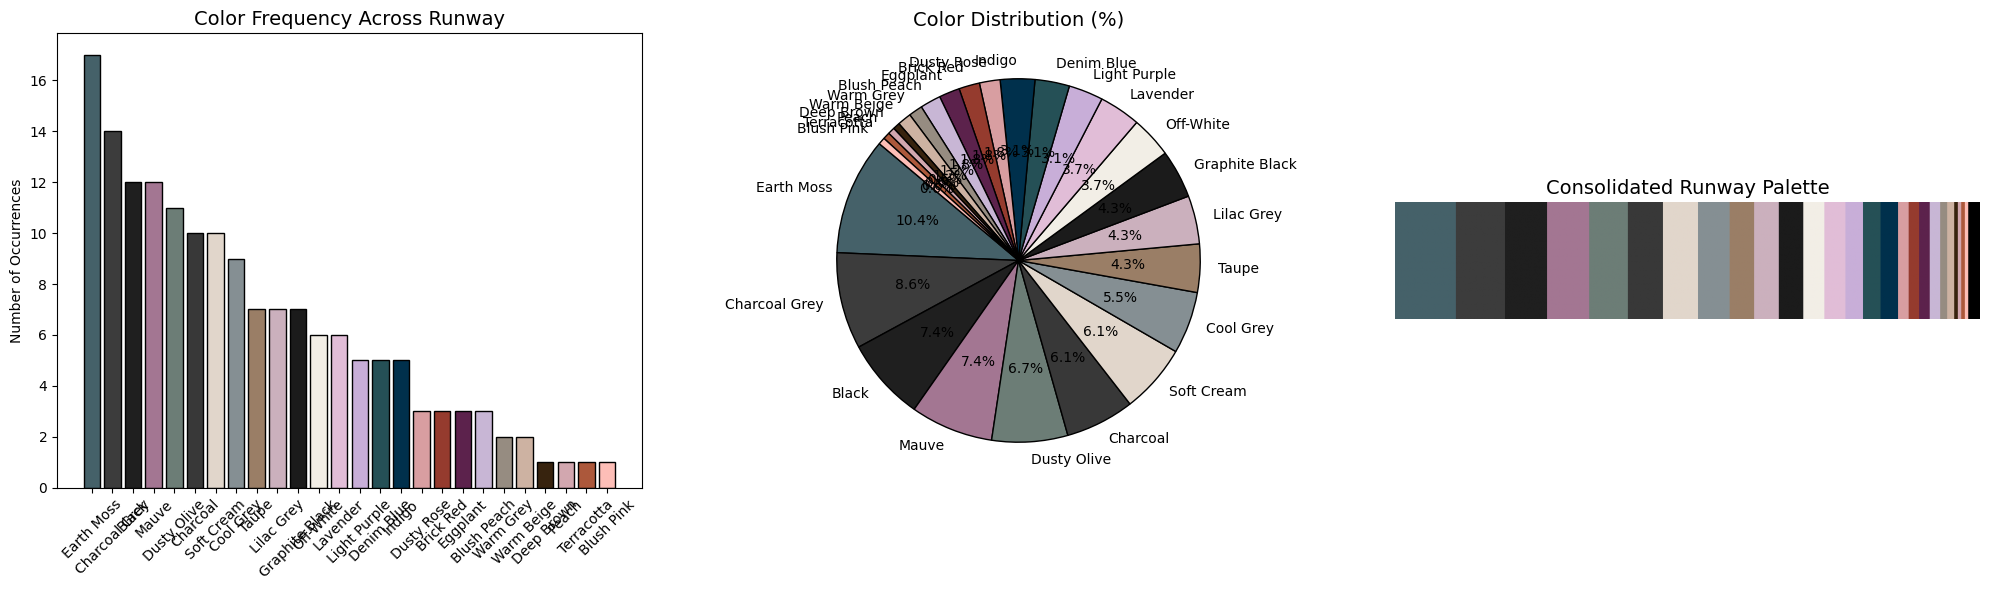

In [27]:
def name_to_lab(colour_name):
    lab_val = np.uint8([[COLOURS[colour_name]]])
    rgb_val = cv2.cvtColor(lab_val, cv2.COLOR_LAB2RGB)[0][0]
    return rgb_val / 255.0

plot_colours = [name_to_lab(colour) for colour in names]
for colour in names:
    lab = np.uint8([[COLOURS.get(colour, [0,0,0])]])
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)[0][0]/255.0
    plot_colours.append(rgb)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
# A. Bar Chart: Frequency
axes[0].bar(names, counts, color=plot_colours, edgecolor='black')
axes[0].set_title('Color Frequency Across Runway', fontsize=14)
axes[0].set_ylabel('Number of Occurrences')
axes[0].tick_params(axis='x', rotation=45)

# B. Percentage Chart: Distribution
axes[1].pie(percentages, labels=names, autopct='%1.1f%%', 
            colors=plot_colours, startangle=140, wedgeprops={'edgecolor': 'black'})
axes[1].set_title('Color Distribution (%)', fontsize=14)

# C. Color Palette: The "Runway Palette"
# We create a simple strip showing the dominant colors in order
palette_img = np.zeros((100, 500, 3))
start = 0
for i, perc in enumerate(percentages):
    end = start + int((perc / 100) * 500)
    palette_img[:, start:end] = plot_colours[i]
    start = end

axes[2].imshow(palette_img)
axes[2].axis('off')
axes[2].set_title('Consolidated Runway Palette', fontsize=14)

plt.tight_layout()
plt.show()

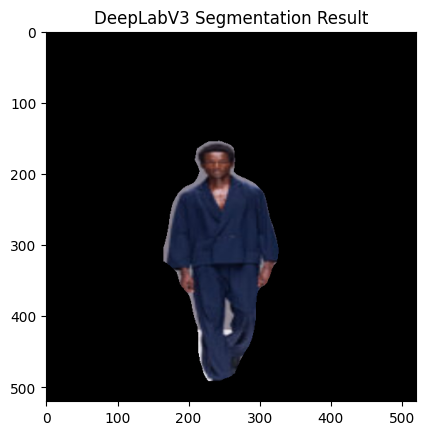

In [28]:
# Show the result of DeepLabV3 for the first image
plt.imshow(garment_img[hawa][10])
plt.title("DeepLabV3 Segmentation Result")
plt.show()

SIHLOUETTE EXTRACTION - VGG16

PREPROCESSING

In [29]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt

In [30]:
mini_CNN = models.vgg16(weights='DEFAULT').features
mini_CNN.eval()
pool = nn.AdaptiveAvgPool2d((1,1))

vgg_processing = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

cleaned_img = {}

In [ ]:
features = {}
for hawa, masks in seg_masks.items():
    garment_masks[hawa] = (masks == 15).cpu().numpy().astype(np.uint8)

    post_silhouette_masks = []
    vgg_features = []

    for i in range(garment_masks[hawa].shape[0]):
        one_mask = garment_masks[hawa][i]
        kernel = np.ones((5,5), np.uint8)
        closed_mask = cv2.morphologyEx(one_mask, cv2.MORPH_CLOSE, kernel)

        contours, _ = cv2.findContours(closed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
       
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            refined_silhouette = np.zeros_like(closed_mask)
            cv2.drawContours(refined_silhouette, [largest_contour], -1, 255, thickness=cv2.FILLED)
            
            x, y, w, h = cv2.boundingRect(largest_contour)
            cropped_silhouette = refined_silhouette[y:y+h, x:x+w]
            normalized_silhouette = cv2.resize(cropped_silhouette, (256, 256), interpolation=cv2.INTER_NEAREST)

            post_silhouette_masks.append(normalized_silhouette)

            rgb_silhouette = cv2.cvtColor(normalized_silhouette, cv2.COLOR_GRAY2RGB)
            cleaned_silhouette = vgg_processing(rgb_silhouette).unsqueeze(0)

            with torch.no_grad():
                vgg_feature = mini_CNN(cleaned_silhouette)
                feature_pooled = pool(vgg_feature).view(-1).numpy()
                vgg_features.append(feature_pooled)
            
            print(f"Processed silhouette {i+1}/{garment_masks[hawa].shape[0]} for {hawa}.")
        else:
            post_silhouette_masks.append(np.zeros((256,256), dtype=np.uint8))
            print(f"No contours found for silhouette {i+1}/{garment_masks[hawa].shape[0]} for {hawa}.")
    
    garment_masks[hawa] = post_silhouette_masks
    features[hawa] = np.array(vgg_features)

Processed silhouette 1/33 for hawa_images.
Processed silhouette 2/33 for hawa_images.
Processed silhouette 3/33 for hawa_images.
Processed silhouette 4/33 for hawa_images.
Processed silhouette 5/33 for hawa_images.
Processed silhouette 6/33 for hawa_images.
Processed silhouette 7/33 for hawa_images.
Processed silhouette 8/33 for hawa_images.
Processed silhouette 9/33 for hawa_images.
Processed silhouette 10/33 for hawa_images.
Processed silhouette 11/33 for hawa_images.
Processed silhouette 12/33 for hawa_images.
Processed silhouette 13/33 for hawa_images.
Processed silhouette 14/33 for hawa_images.
Processed silhouette 15/33 for hawa_images.
Processed silhouette 16/33 for hawa_images.
Processed silhouette 17/33 for hawa_images.
Processed silhouette 18/33 for hawa_images.
Processed silhouette 19/33 for hawa_images.
Processed silhouette 20/33 for hawa_images.
Processed silhouette 21/33 for hawa_images.
Processed silhouette 22/33 for hawa_images.
Processed silhouette 23/33 for hawa_image

Brand: hawa_images
Dominant Type Repetition: 36.4% of collection


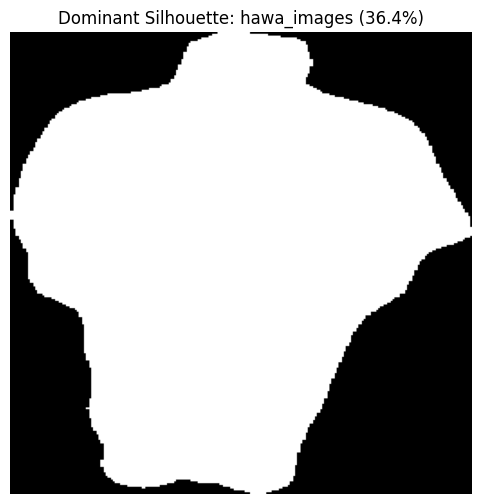

In [33]:
for hawa, dna_matrix in features.items():
    # Group the silhouettes into clusters (e.g., Coats, Trousers, Dresses)
    n_clusters = min(len(dna_matrix), 5) 
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit(dna_matrix)
    
    # Identify the most frequent cluster
    counts = Counter(kmeans.labels_)
    dominant_id, freq = counts.most_common(1)[0]
    repetition_rate = (freq / len(dna_matrix)) * 100

    # Find the real image that best represents this "Dominant Type"
    # (The image closest to the center of the largest cluster)
    center = kmeans.cluster_centers_[dominant_id]
    distances = np.linalg.norm(dna_matrix - center, axis=1)
    best_match_idx = np.argmin(distances)
    representative_sil = garment_masks[hawa][best_match_idx]

    # Display Results
    print(f"Brand: {hawa}")
    print(f"Dominant Type Repetition: {repetition_rate:.1f}% of collection")
    
    plt.figure(figsize=(6,6))
    plt.imshow(representative_sil, cmap='gray')
    plt.title(f"Dominant Silhouette: {hawa} ({repetition_rate:.1f}%)")
    plt.axis('off')
    plt.show()


--- COLLECTION ANALYSIS: hawa_images ---


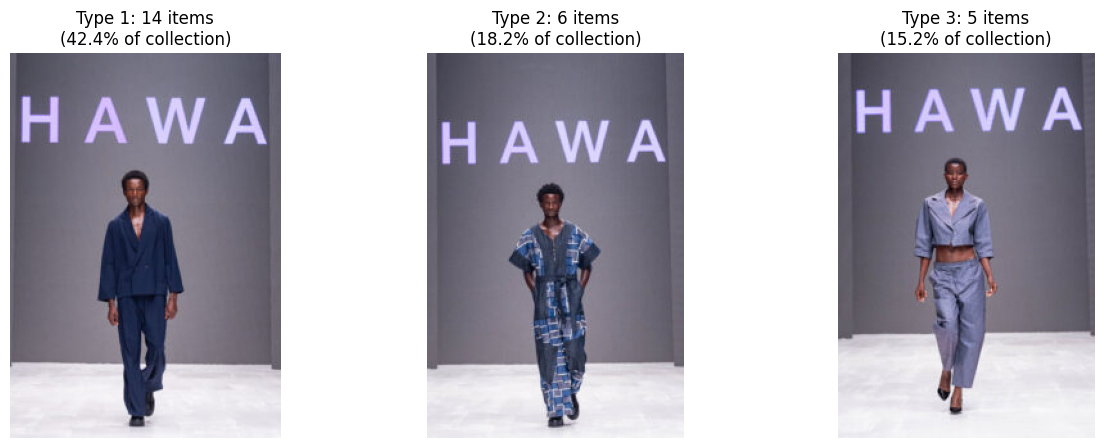

In [34]:
import os

for hawa, dna_matrix in features.items():
    if len(dna_matrix) == 0: continue
        
    # Cluster the collection (e.g., into 5 main categories)
    n_clusters = min(len(dna_matrix), 5) 
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(dna_matrix)
    counts = Counter(kmeans.labels_)
    
    # Get the Top 3 most frequent clusters (the most repeated garments)
    top_3_clusters = counts.most_common(3)

    print(f"\n--- COLLECTION ANALYSIS: {hawa} ---")
    
    plt.figure(figsize=(15, 5))
    for idx, (cluster_id, freq) in enumerate(top_3_clusters):
        # Find the image closest to this cluster center
        center = kmeans.cluster_centers_[cluster_id]
        distances = np.linalg.norm(dna_matrix - center, axis=1)
        best_match_idx = np.argmin(distances)
        
        # --- LINK TO YOUR ORIGINAL FILE PATH ---
        # Using the logic you provided to get the real photo
        folder_path = os.path.join(hawa, dataset_dict[hawa][0])
        all_images = sorted(os.listdir(folder_path))
        img_filename = all_images[best_match_idx]
        full_path = os.path.join(folder_path, img_filename)
        
        # Load and show the real garment
        real_img = cv2.imread(full_path)
        real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, 3, idx + 1)
        plt.imshow(real_img)
        plt.title(f"Type {idx+1}: {freq} items\n({(freq/len(dna_matrix))*100:.1f}% of collection)")
        plt.axis('off')
    
    plt.show()


Brand: hawa_images
Dominant Silhouette found! It represents 36.4% of the collection.


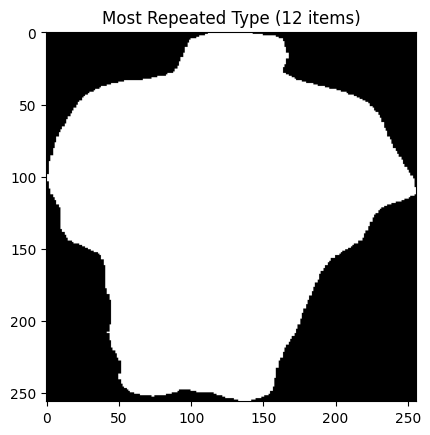

In [36]:
from sklearn.cluster import KMeans
from collections import Counter

# Analyze each brand (hawa) to find repetition
for hawa, dna_matrix in features.items():
    if len(dna_matrix) == 0:
        continue
    
    # 1. Group silhouettes into 5 style categories (e.g., Coats, Dresses, Trousers)
    n_clusters = min(len(dna_matrix), 5) 
    model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit(dna_matrix)
    
    # 2. Find the most repeated cluster
    counts = Counter(model.labels_)
    dominant_id, freq = counts.most_common(1)[0]
    repetition_rate = (freq / len(dna_matrix)) * 100

    # 3. Find the 'Representative' image for this dominant type
    # We find the image closest to the center of the largest cluster
    center = model.cluster_centers_[dominant_id]
    distances = np.linalg.norm(dna_matrix - center, axis=1)
    best_match_idx = np.argmin(distances)
    
    representative_sil = garment_masks[hawa][best_match_idx]

    # --- OUTPUT THE DISCOVERY ---
    print(f"\nBrand: {hawa}")
    print(f"Dominant Silhouette found! It represents {repetition_rate:.1f}% of the collection.")
    
    plt.imshow(representative_sil, cmap='gray')
    plt.title(f"Most Repeated Type ({freq} items)")
    plt.show()